In [1]:
"""
NOTE: This code was originally run with a private dataset from Company X.
Due to data privacy and confidentiality agreements, the actual data is not shared.
Please replace 'your_dataset' with your own data to run the script.
"""

'"\nName : Sathvik Dembale Krishnappagowda\nMatriculation no: 1537732\n\nThis code is a part master\'s thesis project titled:"Generating and Comparing Similarity-Based Feature Vectors for\n                                                 Distinguishing Defect Patterns on Semiconductor Wafer Maps Using a\n                                                 Siamese Neural Network Architecturesand Computer Vision Techniques."\n\n'

# Approach 3: Siamese Architecture with Cosine Embedding Loss

In [2]:
#importing required libraries

import os
import glob2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import time
import sys
import torchvision
import torch.optim as optim
from tqdm import tqdm
from statistics import mean
import itertools
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Setting seed to ensure that the random numbers generated are deterministic.
random_seed = 2
torch.manual_seed(random_seed) 

In [4]:
# Main folder where the class wise images are stored in the respective folders
"""
Original dataset contains the typical semiconductor wafer defects. The defects are similar to the the types of defects 
found in the open source kaggle dataset : https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map
"""

print(os.listdir("./your_dataset"))

['Donut', 'Scratch', 'Random', 'Edge-loc', 'Edge-ring', 'Center', 'Near-Full', 'None', 'Blacklist', 'Loc']


In [5]:
"""
Storing the path of each class in a variable with the class name.

"""

donut_path = "./Donut"
scratch_path = "./Scratch"
random_path = "./Random"
edgeloc_path = "./Edge-loc"
edgering_path = "./Edge-ring"
center_path = "./Center"
nearfull_path = "./Near-Full"
loc_path = "./Loc"
none_path = "./None"

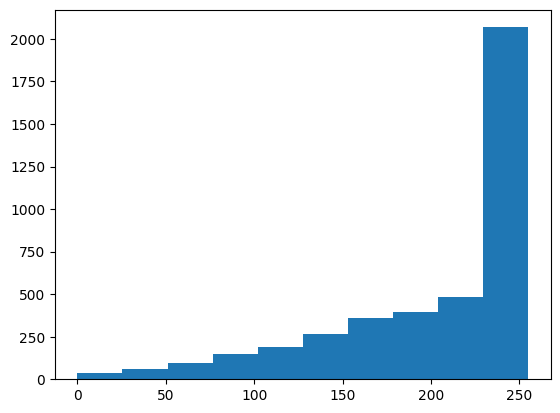

In [6]:
# Histogram of unnormalized pixels ranging from 0 - 255.

unnorm_img = cv2.imread(os.path.join(random_path,"9.png"))
unnorm_img = cv2.cvtColor(unnorm_img , cv2.COLOR_RGB2GRAY)
unnorm_img = np.array(unnorm_img)

pixels =[]
for i in range(64):
    for j in range(64):
        pixels.append(unnorm_img[i][j])


plt.hist(pixels)
plt.show()

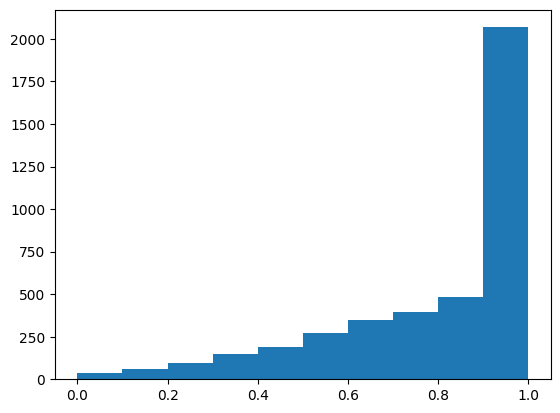

In [7]:
# Histogram of normalized pixels ranging from 0 - 1.

unnorm_img = cv2.imread(os.path.join(random_path,"9.png"))
unnorm_img = cv2.cvtColor(unnorm_img , cv2.COLOR_RGB2GRAY)

img = np.array(unnorm_img)
min_val = np.min(unnorm_img)
max_val = np.max(unnorm_img)

if max_val != min_val:
    img = (unnorm_img - min_val) / (max_val - min_val)
else:
    img = np.ones_like(unnorm_img)

pixels =[]
for i in range(64):
    for j in range(64):
        pixels.append(img[i][j])


plt.hist(pixels)
plt.show()

In [8]:
def read_imgs(class_name, path):
    labeled_imgs = []
    for filename in os.listdir(path):
        
        # Reading images from each folders
        img = cv2.imread(os.path.join(path,filename))
        
        #converting images from RGB to grayscle images with single channel.
        img = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
    
        #Min - max normalizing images
        min_val = np.min(img)
        max_val = np.max(img)

        if max_val != min_val:
            img = (img - min_val) / (max_val - min_val)
        else:
            img = np.ones_like(img)
        
        #Label encoding = {donut:0, scratch:1, Random:2, Edge-loc:3, Edge-ring:4, center:5, Near-Full:6, Loc:7, None:8, Blacklist:9}
        if class_name == "donut":
            labeled_imgs.append((img, 0))
        elif class_name == "scratch":
            labeled_imgs.append((img, 1)) 
        elif class_name == "random":
            labeled_imgs.append((img, 2))
        elif class_name == "edgeloc":
            labeled_imgs.append((img, 3))
        elif class_name == "edgering":
            labeled_imgs.append((img, 4))
        elif class_name == "center":
            labeled_imgs.append((img, 5))
        elif class_name == "nearfull":
            labeled_imgs.append((img, 6))
        elif class_name == "loc":
            labeled_imgs.append((img, 7))
        elif class_name == "none":
            labeled_imgs.append((img, 8))
        elif class_name == "blacklist":
            labeled_imgs.append((img, 9))
        
    return labeled_imgs


In [9]:
donut = read_imgs("donut", donut_path)
scratch = read_imgs("scratch", scratch_path)
random_ = read_imgs("random", random_path)
edgeloc = read_imgs("edgeloc", edgeloc_path)
edgering = read_imgs("edgering", edgering_path)
center = read_imgs("center", center_path)
nearfull = read_imgs("nearfull", nearfull_path)
loc = read_imgs("loc", loc_path)
none = read_imgs("none", none_path)
#blacklist_imgs = read_imgs("blacklist", blacklist_path)

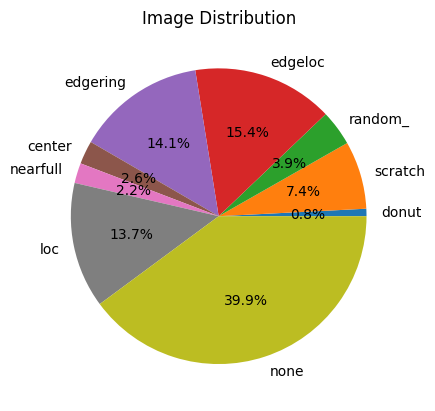

In [10]:
#Class distribution representation with Pie chart.
image_dict = {
    'donut': len(donut),
    'scratch': len(scratch),
    'random_': len(random_),
    'edgeloc': len(edgeloc),
    'edgering': len(edgering),
    'center': len(center),
    'nearfull':len(nearfull),
    'loc': len(loc),
    'none': len(none)
}

classes = list(image_dict.keys())
image_counts = list(image_dict.values())

# Create the pie chart
plt.pie(image_counts, labels=classes, autopct='%1.1f%%')

plt.title('Image Distribution')

plt.show()

In [11]:
# Function to Split 10% data of each class as a test dataset.

def split_data(images, test_size= 0.1):
    # Random seed for reproducibility
    random_seed = 42
    train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=random_seed)
    return train_imgs, test_imgs

donut_train, donut_test = split_data(donut)
scratch_train, scratch_test = split_data(scratch)
random_train, random_test = split_data(random_)
edgeloc_train, edgeloc_test = split_data(edgeloc)
edgering_train, edgering_test = split_data(edgering)
center_train, center_test = split_data(center)
nearfull_train, nearfull_test = split_data(nearfull)
loc_train, loc_test = split_data(loc)
none_train, none_test = split_data(none)


In [12]:
print(len(donut_train) ,len(donut_test))
print(len(scratch_train), len(scratch_test))
print(len(random_train), len(random_test))
print(len(edgeloc_train), len(edgeloc_test))
print(len(edgering_train), len(edgering_test))
print(len(center_train), len(center_test))
print(len(nearfull_train), len(nearfull_test))
print(len(loc_train), len(loc_test))
print(len(none_train), len(none_test))

74 9
686 77
359 40
1423 159
1303 145
235 27
203 23
1269 142
3684 410


In [16]:
#Function to create image similar and dissimilar image pairs

def make_pair(data_req, pairing_size, _1, _2, _3, _4, _5, _6, _7, _8):
    positive_pair = []

    for i in range(len(data_req)):
        choice = np.random.choice(len(data_req), size= pairing_size, replace=False)
        for j in range(len(choice)):
            img_1 = data_req[i][0]
            img_2 = data_req[choice[j]][0]
            
            label1 = data_req[i][1]
            label2 = data_req[choice[j]][1]
            
            positive_pair.append((img_1, img_2, label1, label2, 1))

    print("length of positive pair: ", len(positive_pair))    

    #------------------non cat class----------------------
    non_data = list(itertools.chain(_1, _2, _3 ,_4, _5, _6, _7, _8))

    negative_pair =[]
     
    for i in range(len(data_req)):
        choice = np.random.choice(len(non_data), size= pairing_size, replace=False)
      
        for j in range(len(choice)):
            img_1 = data_req[i][0]
            img_2 = non_data[choice[j]][0]
            
            label1 = data_req[i][1]
            label2 = non_data[choice[j]][1]
            
            negative_pair.append((img_1, img_2,  label1, label2, -1))

    print("length of negative pair", len(negative_pair))


    final_data = list(itertools.chain(positive_pair, negative_pair))
   
    random.shuffle(final_data)
    print("=========length of train per class data========: ", len(final_data))
    
    return final_data

In [17]:
print(len(donut_train) ,len(donut_test))
print(len(scratch_train), len(scratch_test))
print(len(random_train), len(random_test))
print(len(edgeloc_train), len(edgeloc_test))
print(len(edgering_train), len(edgering_test))
print(len(center_train), len(center_test))
print(len(nearfull_train), len(nearfull_test))
print(len(loc_train), len(loc_test))
print(len(none_train), len(none_test))

74 9
686 77
359 40
1423 159
1303 145
235 27
203 23
1269 142
3684 410


In [18]:
print("For donut class")
donut_pairs = make_pair(donut_train, 74, scratch, random_, edgeloc, edgering, center,nearfull, loc, none)
print("For scratch class")
scratch_pairs = make_pair(scratch_train, 8, donut, random_, edgeloc, edgering, center,nearfull, loc, none)
print("For random class")
random_pairs = make_pair(random_train, 15, scratch, donut, edgeloc, edgering, center,nearfull, loc, none)
print("For edgeloc class")
edgeloc_pairs = make_pair(edgeloc_train, 4, scratch, random_, donut, edgering, center,nearfull, loc, none)
print("For edgering class")
edgering_pairs = make_pair(edgering_train, 4, scratch, random_, edgeloc, donut, center,nearfull, loc, none)
print("For center class")
center_pairs = make_pair(center_train, 24, scratch, random_, edgeloc, edgering, donut,nearfull, loc, none)
print("For nearfull class")
nearfull_pairs = make_pair(nearfull_train, 28, scratch, random_, edgeloc, edgering, center,donut, loc, none)
print("For loc class")
loc_pairs = make_pair(loc_train, 4, scratch, random_, edgeloc, edgering, center,nearfull, donut, none)
print("For none class")
none_pairs = make_pair(none_train, 2, scratch, random_, edgeloc, edgering, center,nearfull, loc, donut)

For donut class
length of positive pair:  5476
length of negative pair 5476
=========length of train per class data========:  10952
For scratch class
length of positive pair:  5488
length of negative pair 5488
=========length of train per class data========:  10976
For random class
length of positive pair:  5385
length of negative pair 5385
=========length of train per class data========:  10770
For edgeloc class
length of positive pair:  5692
length of negative pair 5692
=========length of train per class data========:  11384
For edgering class
length of positive pair:  5212
length of negative pair 5212
=========length of train per class data========:  10424
For center class
length of positive pair:  5640
length of negative pair 5640
=========length of train per class data========:  11280
For nearfull class
length of positive pair:  5684
length of negative pair 5684
=========length of train per class data========:  11368
For loc class
length of positive pair:  5076
length of negative 

In [20]:
#Combining and shuffling the image pairs
combined_data = donut_pairs + scratch_pairs + random_pairs + edgeloc_pairs + edgering_pairs + \
                  center_pairs + nearfull_pairs + loc_pairs + none_pairs
                                 
print(len(combined_data))
random.shuffle(combined_data)

102042


In [21]:
#splitting data into training, validation 

train_, val_ = train_test_split(combined_data, test_size=0.1, random_state=42)

In [28]:
#Setting device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
#Creating a custom dataset for pytorch framework to take care of image pairs

class SiameseNetworkDataset(Dataset):
    def __init__(self,image_pairs,transform=None):
        self.image_pairs = image_pairs    
        self.transform = transform
        self.pil_img = transforms.ToPILImage()
        
    def __getitem__(self,index):
        img1 =  self.image_pairs[index][0]
        img2 =  self.image_pairs[index][1]
        
        label1 = self.image_pairs[index][2]
        label2 = self.image_pairs[index][3]
        
        sim_label = self.image_pairs[index][4]
       
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
            label1 = torch.from_numpy(np.array([label1], dtype=np.float32))
            label2 = torch.from_numpy(np.array([label2], dtype=np.float32))
            
            sim_label = torch.from_numpy(np.array([sim_label], dtype=np.float32))
        
        return (img1, img2, label1, label2, sim_label)
    
    def __len__(self):
        return len(self.image_pairs)

In [30]:
# Adding data augumentation to images

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()   
])

In [31]:
train_data = SiameseNetworkDataset(train_ , transform=transformation)
val_data = SiameseNetworkDataset(val_ , transform=transformation)

In [32]:
random_seed = 2
torch.manual_seed(random_seed) 

In [38]:
#Setting data loaders

train_loader = DataLoader(train_data, batch_size = 100, shuffle=True, num_workers= 6)
val_loader = DataLoader(val_data, batch_size= 100, shuffle=True, num_workers= 6)

In [50]:
#Siamese network architecture

class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 30, kernel_size=10),
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(30),
            nn.Dropout2d(p=0.2),
 
            nn.Conv2d(30, 20, kernel_size=5),
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(20),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(20, 10, kernel_size=3),
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(10),
            nn.Dropout2d(p=0.2)
        )

        self.fc = nn.Sequential(
            nn.Linear(10*49*49, 600),
            nn.SiLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(600, 300),
            nn.SiLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(300, 100)
        )

        
    def forward(self, x):
        # Pass the input images through the CNNs
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        # Compute the feature vectors using the fully-connected layer
        out = self.fc(out)
        return out


class SiameseNetwork(nn.Module):
    def __init__(self, base_network):
        super(SiameseNetwork, self).__init__()
        self.base_network = base_network
        
    def forward(self, x1, x2):
        output1 = self.base_network(x1)
        output2 = self.base_network(x2)

        return output1, output2
    

In [51]:
# Initialize the base network and the siamese network
base_network = BaseNetwork().to(device)
network = SiameseNetwork(base_network).to(device)

optimizer = optim.Adam(network.parameters(), lr = 0.0001 , weight_decay=0.00001)
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size= 20 , gamma=0.1)
criterion = nn.CosineEmbeddingLoss(margin = 0.2)
epochs = 100

In [52]:
#Training loop function

def train(net, num_epochs, training_data, validation_data, trainloader, valloader, name = None):    
    epoch_loss_train =[]
    epoch_loss_val =[]
    tolerance = 0
    for epoch in range(num_epochs):
        running_train =[]
        running_val =[]
        running_loss_train = 0
        running_loss_val = 0
        net.train()
        print("Mode: training   |   epoch: {}".format(epoch+1))
        for batch_idx, data in enumerate(tqdm(trainloader)):
            
            (img1,img2, _, _, label) = data
            img1 = img1.to(device).view(-1,1,64,64).float()
            img2 = img2.to(device).view(-1,1,64,64).float()
            label = label.float().to(device).view(-1)
            optimizer.zero_grad()
            embed1, embed2 = net(img1, img2)
    
            loss = criterion(embed1, embed2, label)
            running_loss_train += loss.item()
            loss.backward()
            optimizer.step()
            
        print(scheduler.get_last_lr())
        train_loss_per_epoch = (running_loss_train)/len(train_data)
        epoch_loss_train.append(train_loss_per_epoch)
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch {} loss :{}".format(epoch+1, train_loss_per_epoch))
        
        net.eval()
        print("Mode: validation   |   epoch: {}".format(epoch+1))
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(valloader)):
                (img1,img2, _, _, label) = data
                img1 = img1.to(device).view(-1,1,64,64).float()
                img2 = img2.to(device).view(-1,1,64,64).float()
                label = label.float().to(device).view(-1)
                embed1, embed2 = net(img1, img2)
                
                loss = criterion(embed1, embed2, label)
                running_loss_val += loss.item()
                
        val_loss_per_epoch = (running_loss_val)/(len(val_data))
        
        epoch_loss_val.append(val_loss_per_epoch)
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch {} loss :{}".format(epoch+1, val_loss_per_epoch))          
        
        if (val_loss_per_epoch >= train_loss_per_epoch):
            tolerance += 1
        else:
            tolerance = 0
            
        if tolerance >= 2:
            #torch.save(net.state_dict(), os.path.join("./", str(name) + ".pt"))   
            print("Trained model is early stopped and saved at {} epoch".format(epoch+1))
            break
        
    return epoch_loss_train, epoch_loss_val, epoch+1

In [141]:
train_loss, val_loss, epochs = train(network, epochs, train_data, val_data, train_loader, val_loader, name = "Elmos_contra_donut" )

Mode: training   |   epoch: 1


100%|██████████| 919/919 [00:28<00:00, 32.00it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 1 loss :0.002200290675194396
Mode: validation   |   epoch: 1


100%|██████████| 103/103 [00:01<00:00, 60.81it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 1 loss :0.0015839539238309698
Mode: training   |   epoch: 2


100%|██████████| 919/919 [00:28<00:00, 32.25it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 2 loss :0.0016820308916308134
Mode: validation   |   epoch: 2


100%|██████████| 103/103 [00:01<00:00, 57.20it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 2 loss :0.0013730738134958883
Mode: training   |   epoch: 3


100%|██████████| 919/919 [00:28<00:00, 31.92it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 3 loss :0.0014677760677778101
Mode: validation   |   epoch: 3


100%|██████████| 103/103 [00:01<00:00, 60.18it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 3 loss :0.0012324975802581839
Mode: training   |   epoch: 4


100%|██████████| 919/919 [00:28<00:00, 32.34it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 4 loss :0.0012621485584084278
Mode: validation   |   epoch: 4


100%|██████████| 103/103 [00:01<00:00, 58.51it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 4 loss :0.0009087212907587529
Mode: training   |   epoch: 5


100%|██████████| 919/919 [00:28<00:00, 32.46it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 5 loss :0.0010331726153351302
Mode: validation   |   epoch: 5


100%|██████████| 103/103 [00:01<00:00, 60.76it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 5 loss :0.0007503583494323776
Mode: training   |   epoch: 6


100%|██████████| 919/919 [00:28<00:00, 32.10it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 6 loss :0.000873353788384471
Mode: validation   |   epoch: 6


100%|██████████| 103/103 [00:01<00:00, 59.48it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 6 loss :0.0005899522272848955
Mode: training   |   epoch: 7


100%|██████████| 919/919 [00:28<00:00, 31.97it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 7 loss :0.000746197024132146
Mode: validation   |   epoch: 7


100%|██████████| 103/103 [00:01<00:00, 60.67it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 7 loss :0.0004690308893160572
Mode: training   |   epoch: 8


100%|██████████| 919/919 [00:28<00:00, 31.91it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 8 loss :0.000626554529120641
Mode: validation   |   epoch: 8


100%|██████████| 103/103 [00:01<00:00, 59.13it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 8 loss :0.00040405156434911074
Mode: training   |   epoch: 9


100%|██████████| 919/919 [00:28<00:00, 32.26it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 9 loss :0.0005454637313317749
Mode: validation   |   epoch: 9


100%|██████████| 103/103 [00:01<00:00, 61.34it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 9 loss :0.0002982191928723505
Mode: training   |   epoch: 10


100%|██████████| 919/919 [00:28<00:00, 32.10it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 10 loss :0.00046637624647036604
Mode: validation   |   epoch: 10


100%|██████████| 103/103 [00:01<00:00, 61.52it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 10 loss :0.0002738405526686407
Mode: training   |   epoch: 11


100%|██████████| 919/919 [00:28<00:00, 32.48it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 11 loss :0.0004252960459034317
Mode: validation   |   epoch: 11


100%|██████████| 103/103 [00:01<00:00, 61.91it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 11 loss :0.0002935929167655236
Mode: training   |   epoch: 12


100%|██████████| 919/919 [00:28<00:00, 32.17it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 12 loss :0.0003886504131589404
Mode: validation   |   epoch: 12


100%|██████████| 103/103 [00:01<00:00, 59.95it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 12 loss :0.00023517918806134768
Mode: training   |   epoch: 13


100%|██████████| 919/919 [00:28<00:00, 32.15it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 13 loss :0.0003588129738448268
Mode: validation   |   epoch: 13


100%|██████████| 103/103 [00:01<00:00, 61.06it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 13 loss :0.00022694971037678154
Mode: training   |   epoch: 14


100%|██████████| 919/919 [00:28<00:00, 32.22it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 14 loss :0.00033704575047066734
Mode: validation   |   epoch: 14


100%|██████████| 103/103 [00:01<00:00, 60.60it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 14 loss :0.00021251072292444276
Mode: training   |   epoch: 15


100%|██████████| 919/919 [00:28<00:00, 31.97it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 15 loss :0.0003173946258338017
Mode: validation   |   epoch: 15


100%|██████████| 103/103 [00:01<00:00, 58.73it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 15 loss :0.0002030278054624522
Mode: training   |   epoch: 16


100%|██████████| 919/919 [00:28<00:00, 32.22it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 16 loss :0.0003078703693751048
Mode: validation   |   epoch: 16


100%|██████████| 103/103 [00:01<00:00, 58.48it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 16 loss :0.0001987355841183533
Mode: training   |   epoch: 17


100%|██████████| 919/919 [00:28<00:00, 32.29it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 17 loss :0.00029302437162656905
Mode: validation   |   epoch: 17


100%|██████████| 103/103 [00:01<00:00, 60.58it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 17 loss :0.00021953270987925584
Mode: training   |   epoch: 18


100%|██████████| 919/919 [00:28<00:00, 32.13it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 18 loss :0.00028137373754977095
Mode: validation   |   epoch: 18


100%|██████████| 103/103 [00:01<00:00, 60.89it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 18 loss :0.00021822452136058276
Mode: training   |   epoch: 19


100%|██████████| 919/919 [00:28<00:00, 32.30it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 19 loss :0.0002746098643994242
Mode: validation   |   epoch: 19


100%|██████████| 103/103 [00:01<00:00, 61.10it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 19 loss :0.00019760900215990248
Mode: training   |   epoch: 20


100%|██████████| 919/919 [00:28<00:00, 32.54it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 20 loss :0.0002674648743921271
Mode: validation   |   epoch: 20


100%|██████████| 103/103 [00:01<00:00, 58.95it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 20 loss :0.00019146414601733402
Mode: training   |   epoch: 21


100%|██████████| 919/919 [00:28<00:00, 32.44it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 21 loss :0.0002642562836444058
Mode: validation   |   epoch: 21


100%|██████████| 103/103 [00:01<00:00, 61.32it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 21 loss :0.00019661769874792481
Mode: training   |   epoch: 22


100%|██████████| 919/919 [00:28<00:00, 32.17it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 22 loss :0.0002599273789769014
Mode: validation   |   epoch: 22


100%|██████████| 103/103 [00:01<00:00, 60.13it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 22 loss :0.00020430673799224952
Mode: training   |   epoch: 23


100%|██████████| 919/919 [00:28<00:00, 32.03it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 23 loss :0.0002528626446028806
Mode: validation   |   epoch: 23


100%|██████████| 103/103 [00:01<00:00, 61.95it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 23 loss :0.00019014230579384665
Mode: training   |   epoch: 24


100%|██████████| 919/919 [00:28<00:00, 32.05it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 24 loss :0.00024962109783388206
Mode: validation   |   epoch: 24


100%|██████████| 103/103 [00:01<00:00, 60.79it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 24 loss :0.0001850712036522651
Mode: training   |   epoch: 25


100%|██████████| 919/919 [00:28<00:00, 32.37it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 25 loss :0.000249045626496525
Mode: validation   |   epoch: 25


100%|██████████| 103/103 [00:01<00:00, 58.81it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 25 loss :0.00018551822413740384
Mode: training   |   epoch: 26


100%|██████████| 919/919 [00:28<00:00, 32.38it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 26 loss :0.0002417923077071149
Mode: validation   |   epoch: 26


100%|██████████| 103/103 [00:01<00:00, 61.45it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 26 loss :0.00018675046861377632
Mode: training   |   epoch: 27


100%|██████████| 919/919 [00:28<00:00, 31.99it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 27 loss :0.00023762459789520378
Mode: validation   |   epoch: 27


100%|██████████| 103/103 [00:01<00:00, 59.83it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 27 loss :0.00018665205634395637
Mode: training   |   epoch: 28


100%|██████████| 919/919 [00:28<00:00, 32.18it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 28 loss :0.0002348382747782301
Mode: validation   |   epoch: 28


100%|██████████| 103/103 [00:01<00:00, 60.98it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 28 loss :0.00018538242580092804
Mode: training   |   epoch: 29


100%|██████████| 919/919 [00:28<00:00, 32.15it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 29 loss :0.00023593073326016518
Mode: validation   |   epoch: 29


100%|██████████| 103/103 [00:01<00:00, 59.91it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 29 loss :0.00018234798911450893
Mode: training   |   epoch: 30


100%|██████████| 919/919 [00:28<00:00, 31.99it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 30 loss :0.00023757147850206182
Mode: validation   |   epoch: 30


100%|██████████| 103/103 [00:01<00:00, 58.80it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 30 loss :0.00017900927047153828
Mode: training   |   epoch: 31


100%|██████████| 919/919 [00:28<00:00, 32.18it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 31 loss :0.00022878378324107064
Mode: validation   |   epoch: 31


100%|██████████| 103/103 [00:01<00:00, 59.54it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 31 loss :0.0001804761284098158
Mode: training   |   epoch: 32


100%|██████████| 919/919 [00:28<00:00, 32.13it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 32 loss :0.0002277035495956269
Mode: validation   |   epoch: 32


100%|██████████| 103/103 [00:01<00:00, 59.83it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 32 loss :0.00018779927624995504
Mode: training   |   epoch: 33


100%|██████████| 919/919 [00:28<00:00, 32.39it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 33 loss :0.00022999838963554288
Mode: validation   |   epoch: 33


100%|██████████| 103/103 [00:01<00:00, 59.68it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 33 loss :0.0001890043583901556
Mode: training   |   epoch: 34


100%|██████████| 919/919 [00:28<00:00, 32.22it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 34 loss :0.00022694562269563026
Mode: validation   |   epoch: 34


100%|██████████| 103/103 [00:01<00:00, 60.49it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 34 loss :0.0001981299180543806
Mode: training   |   epoch: 35


100%|██████████| 919/919 [00:28<00:00, 32.00it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 35 loss :0.00022800690273808746
Mode: validation   |   epoch: 35


100%|██████████| 103/103 [00:01<00:00, 59.36it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 35 loss :0.0008626863046009449
Mode: training   |   epoch: 36


100%|██████████| 919/919 [00:28<00:00, 32.15it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 36 loss :0.0002258042536631497
Mode: validation   |   epoch: 36


100%|██████████| 103/103 [00:01<00:00, 59.45it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 36 loss :0.00019562297693687813
Mode: training   |   epoch: 37


100%|██████████| 919/919 [00:28<00:00, 32.09it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 37 loss :0.0002176911308171635
Mode: validation   |   epoch: 37


100%|██████████| 103/103 [00:01<00:00, 62.73it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 37 loss :0.00019150497529157664
Mode: training   |   epoch: 38


100%|██████████| 919/919 [00:28<00:00, 32.20it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 38 loss :0.00021575098209422066
Mode: validation   |   epoch: 38


100%|██████████| 103/103 [00:01<00:00, 58.76it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 38 loss :0.00020581368053613057
Mode: training   |   epoch: 39


100%|██████████| 919/919 [00:28<00:00, 32.11it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 39 loss :0.00021708581351102187
Mode: validation   |   epoch: 39


100%|██████████| 103/103 [00:01<00:00, 59.01it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 39 loss :0.00018380121443154165
Mode: training   |   epoch: 40


100%|██████████| 919/919 [00:28<00:00, 32.28it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 40 loss :0.00021988563117387593
Mode: validation   |   epoch: 40


100%|██████████| 103/103 [00:01<00:00, 58.67it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 40 loss :0.00018098124715920722
Mode: training   |   epoch: 41


100%|██████████| 919/919 [00:28<00:00, 32.61it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 41 loss :0.00021724030405475943
Mode: validation   |   epoch: 41


100%|██████████| 103/103 [00:01<00:00, 59.72it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 41 loss :0.00018018071383999528
Mode: training   |   epoch: 42


100%|██████████| 919/919 [00:28<00:00, 32.35it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 42 loss :0.00021907823208250224
Mode: validation   |   epoch: 42


100%|██████████| 103/103 [00:01<00:00, 57.61it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 42 loss :0.00017952332436050418
Mode: training   |   epoch: 43


100%|██████████| 919/919 [00:28<00:00, 32.49it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 43 loss :0.00021546329050776603
Mode: validation   |   epoch: 43


100%|██████████| 103/103 [00:01<00:00, 60.58it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 43 loss :0.0001799376037457047
Mode: training   |   epoch: 44


100%|██████████| 919/919 [00:28<00:00, 32.53it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 44 loss :0.00021239504955530584
Mode: validation   |   epoch: 44


100%|██████████| 103/103 [00:01<00:00, 58.43it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 44 loss :0.00017783644026278124
Mode: training   |   epoch: 45


100%|██████████| 919/919 [00:28<00:00, 32.19it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 45 loss :0.00021534770306777946
Mode: validation   |   epoch: 45


100%|██████████| 103/103 [00:01<00:00, 58.75it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 45 loss :0.00017759539284953555
Mode: training   |   epoch: 46


100%|██████████| 919/919 [00:28<00:00, 32.47it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 46 loss :0.00021235147717355433
Mode: validation   |   epoch: 46


100%|██████████| 103/103 [00:01<00:00, 60.18it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 46 loss :0.00018033586894979146
Mode: training   |   epoch: 47


100%|██████████| 919/919 [00:28<00:00, 32.48it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 47 loss :0.0002155382864251462
Mode: validation   |   epoch: 47


100%|██████████| 103/103 [00:01<00:00, 59.09it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 47 loss :0.0001826607261068636
Mode: training   |   epoch: 48


100%|██████████| 919/919 [00:28<00:00, 32.67it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 48 loss :0.00021286197021432282
Mode: validation   |   epoch: 48


100%|██████████| 103/103 [00:01<00:00, 59.78it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 48 loss :0.00017626086628939026
Mode: training   |   epoch: 49


100%|██████████| 919/919 [00:28<00:00, 32.69it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 49 loss :0.0002112712332321041
Mode: validation   |   epoch: 49


100%|██████████| 103/103 [00:01<00:00, 62.07it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 49 loss :0.0001729869860807968
Mode: training   |   epoch: 50


100%|██████████| 919/919 [00:28<00:00, 32.15it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 50 loss :0.0002188939308870982
Mode: validation   |   epoch: 50


100%|██████████| 103/103 [00:01<00:00, 61.04it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 50 loss :0.00017520529188999782
Mode: training   |   epoch: 51


100%|██████████| 919/919 [00:28<00:00, 32.25it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 51 loss :0.00021102025372283918
Mode: validation   |   epoch: 51


100%|██████████| 103/103 [00:01<00:00, 59.34it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 51 loss :0.00018017463107490518
Mode: training   |   epoch: 52


100%|██████████| 919/919 [00:28<00:00, 32.05it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 52 loss :0.00021143133794251215
Mode: validation   |   epoch: 52


100%|██████████| 103/103 [00:01<00:00, 60.13it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 52 loss :0.00017791099829183823
Mode: training   |   epoch: 53


100%|██████████| 919/919 [00:28<00:00, 32.34it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 53 loss :0.00020664535169959643
Mode: validation   |   epoch: 53


100%|██████████| 103/103 [00:01<00:00, 58.70it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 53 loss :0.00018147637539217437
Mode: training   |   epoch: 54


100%|██████████| 919/919 [00:28<00:00, 32.27it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 54 loss :0.0002085667412180364
Mode: validation   |   epoch: 54


100%|██████████| 103/103 [00:01<00:00, 61.36it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 54 loss :0.00018286772481561987
Mode: training   |   epoch: 55


100%|██████████| 919/919 [00:28<00:00, 32.34it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 55 loss :0.00020833574042674
Mode: validation   |   epoch: 55


100%|██████████| 103/103 [00:01<00:00, 60.03it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 55 loss :0.00017818149052965758
Mode: training   |   epoch: 56


100%|██████████| 919/919 [00:28<00:00, 32.60it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 56 loss :0.00020822707981573712
Mode: validation   |   epoch: 56


100%|██████████| 103/103 [00:01<00:00, 60.54it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 56 loss :0.00019791555104896485
Mode: training   |   epoch: 57


100%|██████████| 919/919 [00:28<00:00, 31.88it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 57 loss :0.00020765980111379974
Mode: validation   |   epoch: 57


100%|██████████| 103/103 [00:01<00:00, 59.90it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 57 loss :0.00019243426583828255
Mode: training   |   epoch: 58


100%|██████████| 919/919 [00:28<00:00, 32.25it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 58 loss :0.00020586422178875267
Mode: validation   |   epoch: 58


100%|██████████| 103/103 [00:01<00:00, 60.02it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 58 loss :0.00017626024839802944
Mode: training   |   epoch: 59


100%|██████████| 919/919 [00:28<00:00, 32.19it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 59 loss :0.00020360443941831345
Mode: validation   |   epoch: 59


100%|██████████| 103/103 [00:01<00:00, 59.03it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 59 loss :0.00018184116379433906
Mode: training   |   epoch: 60


100%|██████████| 919/919 [00:28<00:00, 32.35it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 60 loss :0.00020575209017368077
Mode: validation   |   epoch: 60


100%|██████████| 103/103 [00:01<00:00, 60.12it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 60 loss :0.00017299552259086544
Mode: training   |   epoch: 61


100%|██████████| 919/919 [00:28<00:00, 32.33it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 61 loss :0.0002095328382861397
Mode: validation   |   epoch: 61


100%|██████████| 103/103 [00:01<00:00, 61.08it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 61 loss :0.00018081847850082107
Mode: training   |   epoch: 62


100%|██████████| 919/919 [00:28<00:00, 32.63it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 62 loss :0.00020814276742026874
Mode: validation   |   epoch: 62


100%|██████████| 103/103 [00:01<00:00, 60.38it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 62 loss :0.0001814188047320813
Mode: training   |   epoch: 63


100%|██████████| 919/919 [00:28<00:00, 32.23it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 63 loss :0.00020302925784782824
Mode: validation   |   epoch: 63


100%|██████████| 103/103 [00:01<00:00, 59.76it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 63 loss :0.0001758817349046315
Mode: training   |   epoch: 64


100%|██████████| 919/919 [00:28<00:00, 32.16it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 64 loss :0.00020308204179648307
Mode: validation   |   epoch: 64


100%|██████████| 103/103 [00:01<00:00, 61.42it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 64 loss :0.0001806589717880953
Mode: training   |   epoch: 65


100%|██████████| 919/919 [00:28<00:00, 32.21it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 65 loss :0.00020412066030109233
Mode: validation   |   epoch: 65


100%|██████████| 103/103 [00:01<00:00, 60.87it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 65 loss :0.00017811591276251993
Mode: training   |   epoch: 66


100%|██████████| 919/919 [00:28<00:00, 31.97it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 66 loss :0.00020431089692968956
Mode: validation   |   epoch: 66


100%|██████████| 103/103 [00:01<00:00, 61.27it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 66 loss :0.00017419627677865265
Mode: training   |   epoch: 67


100%|██████████| 919/919 [00:28<00:00, 32.11it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 67 loss :0.00020515950935762214
Mode: validation   |   epoch: 67


100%|██████████| 103/103 [00:01<00:00, 61.29it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 67 loss :0.00017732577934063187
Mode: training   |   epoch: 68


100%|██████████| 919/919 [00:28<00:00, 31.93it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 68 loss :0.00020438210595320923
Mode: validation   |   epoch: 68


100%|██████████| 103/103 [00:01<00:00, 58.99it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 68 loss :0.00017505682124746864
Mode: training   |   epoch: 69


100%|██████████| 919/919 [00:28<00:00, 32.13it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 69 loss :0.0002048375844162623
Mode: validation   |   epoch: 69


100%|██████████| 103/103 [00:01<00:00, 59.80it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 69 loss :0.0001778491503130096
Mode: training   |   epoch: 70


100%|██████████| 919/919 [00:28<00:00, 31.99it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 70 loss :0.0002057335818302715
Mode: validation   |   epoch: 70


100%|██████████| 103/103 [00:01<00:00, 59.74it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 70 loss :0.00017443954582855401
Mode: training   |   epoch: 71


100%|██████████| 919/919 [00:28<00:00, 32.27it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 71 loss :0.00019943671088913466
Mode: validation   |   epoch: 71


100%|██████████| 103/103 [00:01<00:00, 59.87it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 71 loss :0.00017172670892123162
Mode: training   |   epoch: 72


100%|██████████| 919/919 [00:28<00:00, 32.58it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 72 loss :0.0001987774542625464
Mode: validation   |   epoch: 72


100%|██████████| 103/103 [00:01<00:00, 59.19it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 72 loss :0.00017447132637562235
Mode: training   |   epoch: 73


100%|██████████| 919/919 [00:28<00:00, 31.82it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 73 loss :0.0002020947952989515
Mode: validation   |   epoch: 73


100%|██████████| 103/103 [00:01<00:00, 61.50it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 73 loss :0.0001769512499324005
Mode: training   |   epoch: 74


100%|██████████| 919/919 [00:28<00:00, 32.70it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 74 loss :0.0002026215023320595
Mode: validation   |   epoch: 74


100%|██████████| 103/103 [00:01<00:00, 59.92it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 74 loss :0.00017677355585622696
Mode: training   |   epoch: 75


100%|██████████| 919/919 [00:28<00:00, 32.00it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 75 loss :0.00020110829103212632
Mode: validation   |   epoch: 75


100%|██████████| 103/103 [00:01<00:00, 59.94it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 75 loss :0.00018001551917325013
Mode: training   |   epoch: 76


100%|██████████| 919/919 [00:28<00:00, 32.23it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 76 loss :0.00020024904612390458
Mode: validation   |   epoch: 76


100%|██████████| 103/103 [00:01<00:00, 58.96it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 76 loss :0.00017856306866237382
Mode: training   |   epoch: 77


100%|██████████| 919/919 [00:28<00:00, 31.94it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 77 loss :0.00019884807227393418
Mode: validation   |   epoch: 77


100%|██████████| 103/103 [00:01<00:00, 59.62it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 77 loss :0.00018103300684241995
Mode: training   |   epoch: 78


100%|██████████| 919/919 [00:28<00:00, 32.29it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 78 loss :0.00020100552699971893
Mode: validation   |   epoch: 78


100%|██████████| 103/103 [00:01<00:00, 60.03it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 78 loss :0.00018171482012432859
Mode: training   |   epoch: 79


100%|██████████| 919/919 [00:28<00:00, 32.04it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 79 loss :0.0002002317885022154
Mode: validation   |   epoch: 79


100%|██████████| 103/103 [00:01<00:00, 61.27it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 79 loss :0.00017776886047900936
Mode: training   |   epoch: 80


100%|██████████| 919/919 [00:28<00:00, 32.29it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 80 loss :0.00020129935924887587
Mode: validation   |   epoch: 80


100%|██████████| 103/103 [00:01<00:00, 60.23it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 80 loss :0.00017770120859561314
Mode: training   |   epoch: 81


100%|██████████| 919/919 [00:28<00:00, 32.24it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 81 loss :0.00020395210619161106
Mode: validation   |   epoch: 81


100%|██████████| 103/103 [00:01<00:00, 60.21it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 81 loss :0.00017686780598610358
Mode: training   |   epoch: 82


100%|██████████| 919/919 [00:28<00:00, 32.33it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 82 loss :0.00019981542217317288
Mode: validation   |   epoch: 82


100%|██████████| 103/103 [00:01<00:00, 60.23it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 82 loss :0.00017756234230866346
Mode: training   |   epoch: 83


100%|██████████| 919/919 [00:28<00:00, 32.79it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 83 loss :0.000200925499661586
Mode: validation   |   epoch: 83


100%|██████████| 103/103 [00:01<00:00, 59.63it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 83 loss :0.00018066185506605993
Mode: training   |   epoch: 84


100%|██████████| 919/919 [00:28<00:00, 31.94it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 84 loss :0.00020090163187213658
Mode: validation   |   epoch: 84


100%|██████████| 103/103 [00:01<00:00, 60.07it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 84 loss :0.00017657538331898332
Mode: training   |   epoch: 85


100%|██████████| 919/919 [00:28<00:00, 32.37it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 85 loss :0.00019873939961553575
Mode: validation   |   epoch: 85


100%|██████████| 103/103 [00:01<00:00, 61.11it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 85 loss :0.0001802339035925354
Mode: training   |   epoch: 86


100%|██████████| 919/919 [00:28<00:00, 32.00it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 86 loss :0.00020115807776215988
Mode: validation   |   epoch: 86


100%|██████████| 103/103 [00:01<00:00, 59.60it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 86 loss :0.00017898314189886111
Mode: training   |   epoch: 87


100%|██████████| 919/919 [00:28<00:00, 32.23it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 87 loss :0.00019864978243232462
Mode: validation   |   epoch: 87


100%|██████████| 103/103 [00:01<00:00, 60.24it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 87 loss :0.0001933769554931789
Mode: training   |   epoch: 88


100%|██████████| 919/919 [00:28<00:00, 32.42it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 88 loss :0.000199632849485418
Mode: validation   |   epoch: 88


100%|██████████| 103/103 [00:01<00:00, 60.85it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 88 loss :0.00018234328130969495
Mode: training   |   epoch: 89


100%|██████████| 919/919 [00:28<00:00, 31.85it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 89 loss :0.00020119571801519156
Mode: validation   |   epoch: 89


100%|██████████| 103/103 [00:01<00:00, 58.35it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 89 loss :0.000175991809060778
Mode: training   |   epoch: 90


100%|██████████| 919/919 [00:28<00:00, 32.46it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 90 loss :0.00019668050085693592
Mode: validation   |   epoch: 90


100%|██████████| 103/103 [00:01<00:00, 59.50it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 90 loss :0.00017721183056709932
Mode: training   |   epoch: 91


100%|██████████| 919/919 [00:28<00:00, 32.16it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 91 loss :0.00019649639907848282
Mode: validation   |   epoch: 91


100%|██████████| 103/103 [00:01<00:00, 59.13it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 91 loss :0.00018085814432470973
Mode: training   |   epoch: 92


100%|██████████| 919/919 [00:28<00:00, 32.12it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 92 loss :0.00020428484414522009
Mode: validation   |   epoch: 92


100%|██████████| 103/103 [00:01<00:00, 60.01it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 92 loss :0.00017998600111906847
Mode: training   |   epoch: 93


100%|██████████| 919/919 [00:28<00:00, 32.14it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 93 loss :0.00019869691301879812
Mode: validation   |   epoch: 93


100%|██████████| 103/103 [00:01<00:00, 59.09it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 93 loss :0.00017477315987679713
Mode: training   |   epoch: 94


100%|██████████| 919/919 [00:28<00:00, 32.69it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 94 loss :0.000197443201571771
Mode: validation   |   epoch: 94


100%|██████████| 103/103 [00:01<00:00, 59.79it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 94 loss :0.0001792939815675371
Mode: training   |   epoch: 95


100%|██████████| 919/919 [00:28<00:00, 32.04it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 95 loss :0.00020056068382982563
Mode: validation   |   epoch: 95


100%|██████████| 103/103 [00:01<00:00, 61.42it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 95 loss :0.00017173199890942344
Mode: training   |   epoch: 96


100%|██████████| 919/919 [00:28<00:00, 31.99it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 96 loss :0.00019578656114287494
Mode: validation   |   epoch: 96


100%|██████████| 103/103 [00:01<00:00, 61.53it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 96 loss :0.0001742832443878035
Mode: training   |   epoch: 97


100%|██████████| 919/919 [00:28<00:00, 32.16it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 97 loss :0.00019843994207958398
Mode: validation   |   epoch: 97


100%|██████████| 103/103 [00:01<00:00, 60.24it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 97 loss :0.00019215156607310625
Mode: training   |   epoch: 98


100%|██████████| 919/919 [00:28<00:00, 32.35it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 98 loss :0.00019709661975279358
Mode: validation   |   epoch: 98


100%|██████████| 103/103 [00:01<00:00, 60.40it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 98 loss :0.00017455023704472701
Mode: training   |   epoch: 99


100%|██████████| 919/919 [00:28<00:00, 32.13it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 99 loss :0.00019996321116516033
Mode: validation   |   epoch: 99


100%|██████████| 103/103 [00:01<00:00, 61.24it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 99 loss :0.00018354864440700165
Mode: training   |   epoch: 100


100%|██████████| 919/919 [00:28<00:00, 32.09it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 100 loss :0.00020071935493058427
Mode: validation   |   epoch: 100


100%|██████████| 103/103 [00:01<00:00, 58.96it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 100 loss :0.000183289149232283


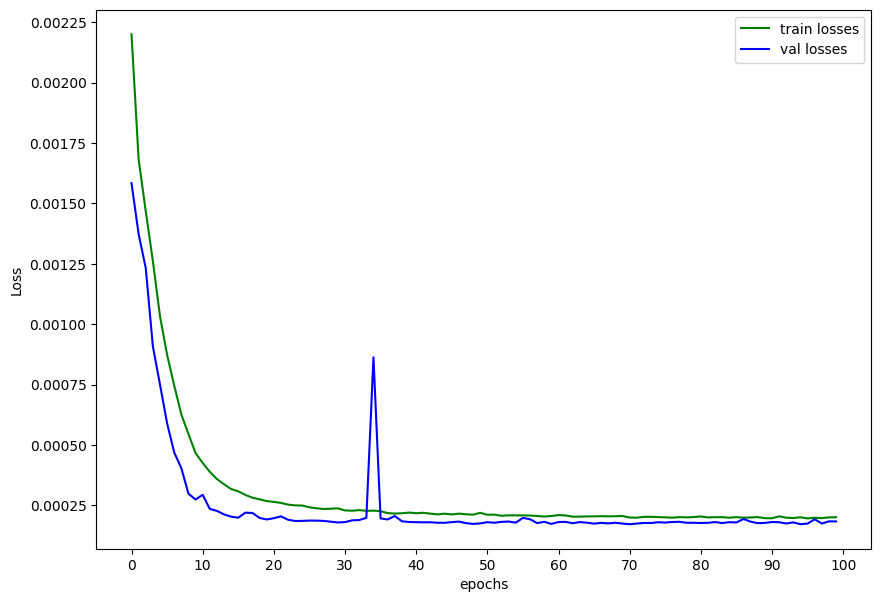

In [146]:
plt.figure(figsize=(10, 7))

plt.plot(train_loss, color='green', label='train losses')
plt.plot(val_loss, color='blue', label='val losses')
plt.xticks(range(0, epochs + 1, 10))
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
#plt.savefig('F:\Chrome downloads\loss_graph.png')
plt.show()

In [148]:
#torch.save(base_network.state_dict(), "./base_net.pt")
#torch.save(network.state_dict(), "./main_net.pt")


In [53]:
load_base_net = BaseNetwork().to(device)
load_siamese_net = SiameseNetwork(load_base_net).to(device)

In [54]:
#Loading the weights of a saved model.

load_base_net.load_state_dict(torch.load("./base_net.pt", map_location=device))
load_siamese_net.load_state_dict(torch.load("./main_net.pt", map_location=device))

<All keys matched successfully>

In [55]:
load_base_net.eval()

BaseNetwork(
  (cnn): Sequential(
    (0): Conv2d(1, 30, kernel_size=(10, 10), stride=(1, 1))
    (1): SiLU(inplace=True)
    (2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(30, 20, kernel_size=(5, 5), stride=(1, 1))
    (5): SiLU(inplace=True)
    (6): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1))
    (9): SiLU(inplace=True)
    (10): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout2d(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=24010, out_features=600, bias=True)
    (1): SiLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=600, out_features=300, bias=True)
    (4): SiLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=

In [56]:
load_siamese_net.eval()

SiameseNetwork(
  (base_network): BaseNetwork(
    (cnn): Sequential(
      (0): Conv2d(1, 30, kernel_size=(10, 10), stride=(1, 1))
      (1): SiLU(inplace=True)
      (2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout2d(p=0.2, inplace=False)
      (4): Conv2d(30, 20, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU(inplace=True)
      (6): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout2d(p=0.2, inplace=False)
      (8): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1))
      (9): SiLU(inplace=True)
      (10): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout2d(p=0.2, inplace=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=24010, out_features=600, bias=True)
      (1): SiLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=600, out_features=300, bias=True)
      (4): SiLU(inplace

In [59]:
class_names = {0:'donut', 1:'scratch', 2:'random', 3:'edgeloc', 4:'edgering', 5:'center', 6:'nearfull', 7:'loc', 8:'none'}

complete_data = donut + scratch + random_ + edgeloc + edgering + center + nearfull + loc + none
random.shuffle(complete_data)

In [60]:
# COnverting raw images into 1D numpy array.

dataset_images =[]
dataset_labels =[]
for (img, labl) in complete_data:
    dataset_images.append(img)
    dataset_labels.append(labl)
      
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)
reshaped_img = dataset_images.reshape(dataset_images.shape[0], -1)
reshaped_labels = dataset_labels.reshape(dataset_images.shape[0], -1)    

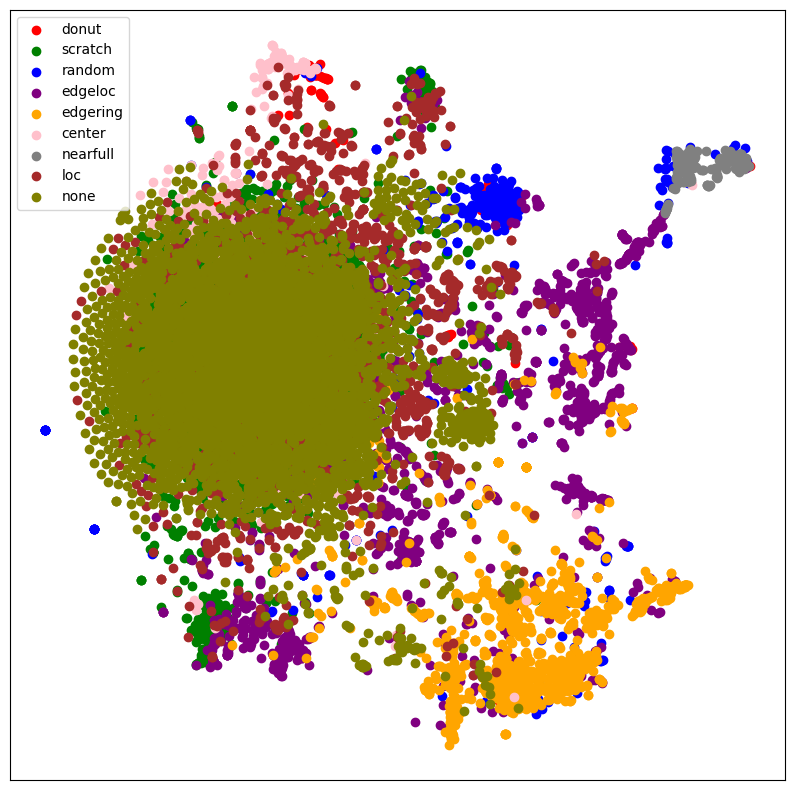

In [61]:
# Plotting 1D raw images in a 2D plot

tsne = TSNE(n_components=2, random_state=42)
imgs_2D = tsne.fit_transform(reshaped_img)

# Plot the results
plt.figure(figsize=(10, 10))
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    plt.scatter(imgs_2D[dataset_labels ==i, 0], imgs_2D[dataset_labels==i, 1], c=colors[i], label=str(class_names[i]))
plt.legend()

# Remove x and y tick labels
plt.xticks([])
plt.yticks([])

plt.savefig('./_gray_tsne_raw_img_2D_plot.png')

plt.show()

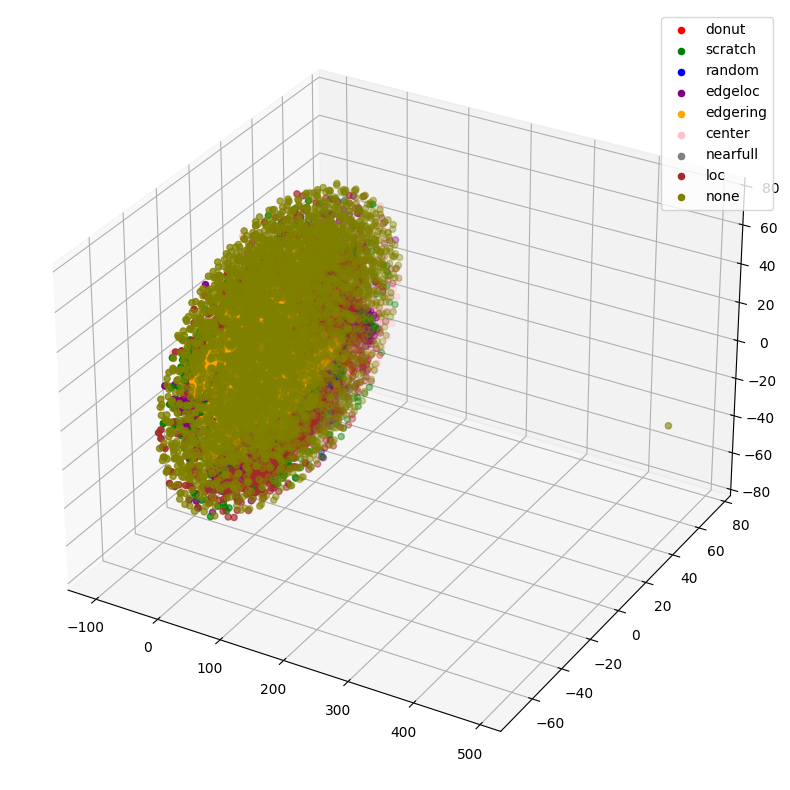

In [62]:
#Plotting 1D raw images in 3D

tsne = TSNE(n_components=3, random_state=42)
imgs_2D = tsne.fit_transform(reshaped_img)

# Plot the results in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    ax.scatter(imgs_2D[dataset_labels==i, 0], imgs_2D[dataset_labels==i, 1], imgs_2D[dataset_labels==i, 2], c=colors[i], label=str(class_names[i]))
ax.legend()
plt.show()

In [63]:
#Generating feature embeddings using the subnetwork of a trained siamese.

embeddings = []
labels = []
with torch.no_grad():
    for (img, label) in complete_data:
       
        img = torch.from_numpy(img)
        img = img.float().to(device)
        img = img.view(1,1,64,64)
        label = torch.from_numpy(np.array([label], dtype=np.float32))
        output = load_base_net(img)
        embeddings.append(output)
        labels.append(label)
        
embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)

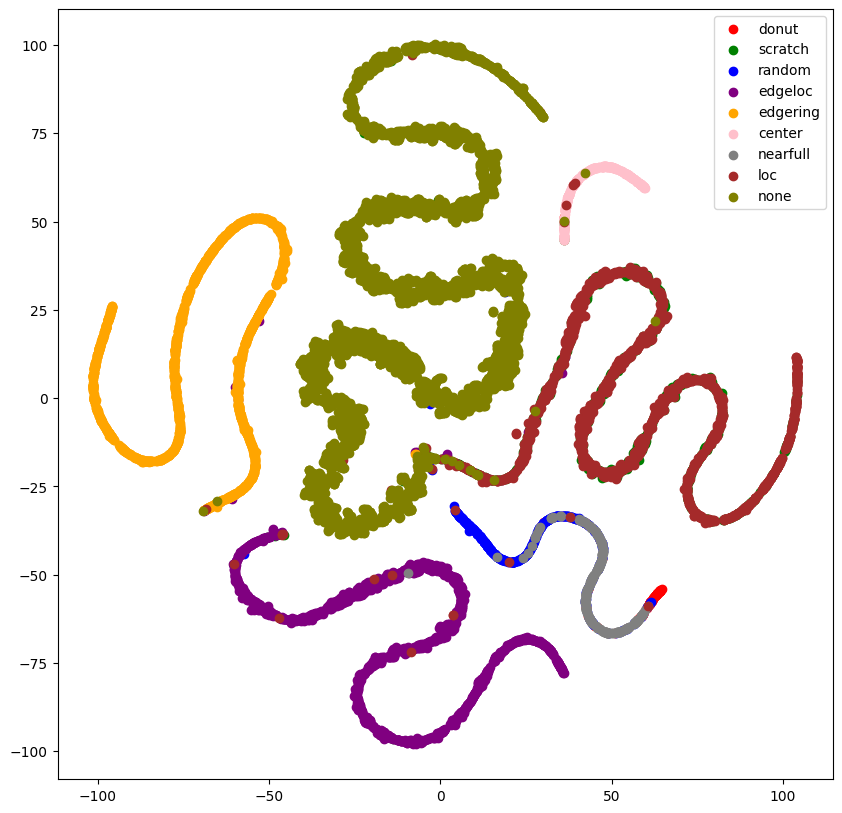

In [160]:
# Plotting the siamese generated embeddings in 2D.

tsne = TSNE(n_components=2, random_state=42)
embeddings_2D = tsne.fit_transform(embeddings.cpu())
labels = labels.cpu()

# Plot the results
plt.figure(figsize=(10, 10))
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    plt.scatter(embeddings_2D[labels ==i, 0], embeddings_2D[labels==i, 1], c=colors[i], label=str(class_names[i]))
plt.legend()
plt.show()

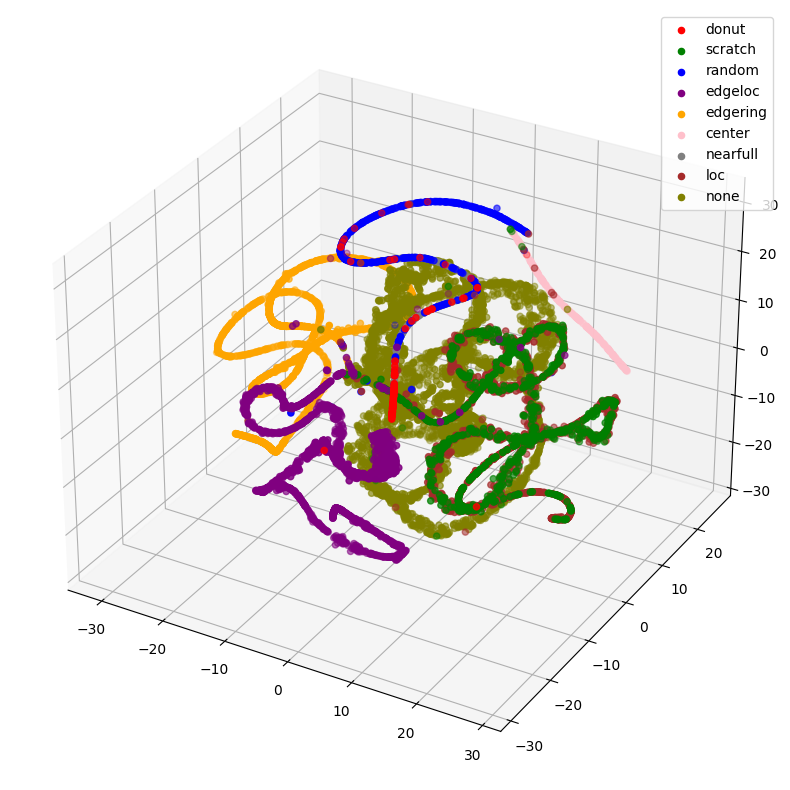

In [161]:
# Plotting the siamese generated embeddings in 3D.

tsne = TSNE(n_components=3, random_state=42)
embeddings_2D = tsne.fit_transform(embeddings.cpu())
labels = labels.cpu()
# Plot the results in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    ax.scatter(embeddings_2D[labels==i, 0], embeddings_2D[labels==i, 1], embeddings_2D[labels==i, 2], c=colors[i], label=str(class_names[i]))
ax.legend()
plt.show()

In [65]:
#Creating list of different class data for easy access.

datasets = [donut, scratch, random_, edgeloc, edgering, center, nearfull, loc, none]

In [66]:
#Function to plot list of images
def plot_ref_imgs(ref_img_lst):
    fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(20, 10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(ref_img_lst[i])
        ax.axis("off")
        ax.set_title(class_names[i])

    # adjust the spacing between the subplots
    fig.subplots_adjust(wspace=0.2)

    # display the figure
    plt.show()

In [67]:
to_tensor = transforms.ToTensor()

## Generating Cosine Similarity Based Fingerprint Vector

## Method 1: Comparing test image with randomly picked image from each class.

In [68]:
# Function to compare the given image with randomly picked image from each class

def similarity_vec_gen(ip_img, data, encoder, label, print_plot = True):
    ref_images = {}
    ip_img = to_tensor(ip_img).view(1,1,64,64).to(device).float()
    
    ip_img_embed = encoder(ip_img)
    
    ref_donut_img = data[0][int(np.random.choice(len(data[0]), size = 1))][0]
    ref_donut  = to_tensor(ref_donut_img).view(1,1,64,64).to(device).float() 
    ref_embed= encoder(ref_donut)
    sim_0 = F.cosine_similarity(ip_img_embed, ref_embed)
    ref_images[0] = ref_donut_img
    
    ref_scratch_img = data[1][int(np.random.choice(len(data[1]), size = 1))][0]
    ref_scratch  = to_tensor(ref_scratch_img).view(1,1,64,64).to(device).float()     
    ref_embed = encoder(ref_scratch)
    sim_1 = F.cosine_similarity(ip_img_embed, ref_embed)
    ref_images[1] = ref_scratch_img

    
    ref_random_img = data[2][int(np.random.choice(len(data[2]), size = 1))][0]
    ref_random  = to_tensor(ref_random_img).view(1,1,64,64).to(device).float()     
    ref_embed= encoder(ref_random)
    sim_2 = F.cosine_similarity(ip_img_embed, ref_embed)
    ref_images[2] = ref_random_img

    
    ref_edgeloc_img = data[3][int(np.random.choice(len(data[3]), size = 1))][0]
    ref_edgeloc  = to_tensor(ref_edgeloc_img).view(1,1,64,64).to(device).float()     
    ref_embed= encoder(ref_edgeloc)
    sim_3 = F.cosine_similarity(ip_img_embed, ref_embed)
    ref_images[3] = ref_edgeloc_img

    
    ref_edgering_img = data[4][int(np.random.choice(len(data[4]), size = 1))][0]
    ref_edgering  = to_tensor(ref_edgering_img).view(1,1,64,64).to(device).float()     
    ref_embed = encoder(ref_edgering)
    sim_4 = F.cosine_similarity(ip_img_embed, ref_embed)
    ref_images[4] = ref_edgering_img

    
    ref_center_img = data[5][int(np.random.choice(len(data[5]), size = 1))][0]
    ref_center  = to_tensor(ref_center_img).view(1,1,64,64).to(device).float()     
    ref_embed= encoder(ref_center)
    sim_5 = F.cosine_similarity(ip_img_embed, ref_embed)
    ref_images[5] = ref_center_img

    
    ref_nearfull_img = data[6][int(np.random.choice(len(data[6]), size = 1))][0]
    ref_nearfull  = to_tensor(ref_nearfull_img).view(1,1,64,64).to(device).float()     
    ref_embed= encoder(ref_nearfull)
    sim_6 = F.cosine_similarity(ip_img_embed, ref_embed)
    ref_images[6] = ref_nearfull_img

    
    ref_loc_img = data[7][int(np.random.choice(len(data[7]), size = 1))][0]
    ref_loc  = to_tensor(ref_loc_img).view(1,1,64,64).to(device).float()     
    ref_embed= encoder(ref_loc)
    sim_7 = F.cosine_similarity(ip_img_embed, ref_embed)
    ref_images[7] = ref_loc_img

    
    ref_none_img = data[8][int(np.random.choice(len(data[8]), size = 1))][0]
    ref_none  = to_tensor(ref_none_img).view(1,1,64,64).to(device).float()     
    ref_embed= encoder(ref_none)
    sim_8 = F.cosine_similarity(ip_img_embed, ref_embed)
    ref_images[8] = ref_none_img
    
    cosine_similarities = torch.cat((sim_0, sim_1, sim_2, sim_3, sim_4, sim_5, sim_6, sim_7, sim_8), dim=0)
    
    cosine_sim_vec = cosine_similarities.detach().cpu().numpy().flatten()
    
    max_idx = np.argmax(cosine_sim_vec)
    
    if print_plot == True:
        print(f"The defect pattern belongs to \033[1mclass:{max_idx}\033[0m with label \033[1m'{class_names[max_idx]}'\033[0m")
        print()
        print("The different randomly picked images from each class for comparision are :")
        plot_ref_imgs(ref_images)

        print(f"The cosine similarity based fingerprint vector :- \n \033[1m{str(cosine_sim_vec)}\033[0m")
    return  cosine_sim_vec , ref_images , max_idx

## Finding mean fingerprint vector

In [79]:
"""
The function iterates and generates multiple fingerprint vectors for a given test image
and returns a mean fingerprint vector and the predicted class label. 
"""
def mean_sim_vector(ip_img, data, model,label, mean_size =10, print_ = True):
    vectors =[]
    for i in range(mean_size):
        similarity_vector, _ , _= similarity_vec_gen(ip_img, data, model, label, print_plot = False)
        vectors.append(similarity_vector)
        
    mean_similarity_vec = np.mean(vectors, axis=0)
    idx_max = np.argmax(mean_similarity_vec)
    
    if print_ == True:
        print(f"The defect pattern belongs to class \033[1m'{label[idx_max]}'\033[0m with \033[1mlabel {idx_max}\033[0m and with cosine similarity of \033[1m{mean_similarity_vec[idx_max]}\033[0m")
        print()
        print(f"Mean similarity feature vector for a input image w.r.t 9 different sets of defect patterns :- \n \033[1m{str(mean_similarity_vec)}\033[0m")

    return mean_similarity_vec , idx_max


In [83]:
#Predicting mean similarity feature vector and the class label for the given image.

similarity_vec , class_label = mean_sim_vector(img, datasets, load_base_net,class_names, mean_size = 1000)

The defect pattern belongs to class 'center' with label 5 and with cosine similarity of 0.9905513525009155

Mean similarity feature vector for a input image w.r.t 9 different sets of defect patterns :- 
 [ 0.09757078  0.11870026  0.09339739 -0.0426225  -0.5869798   0.99055135
  0.09051373  0.10685918  0.13385719]


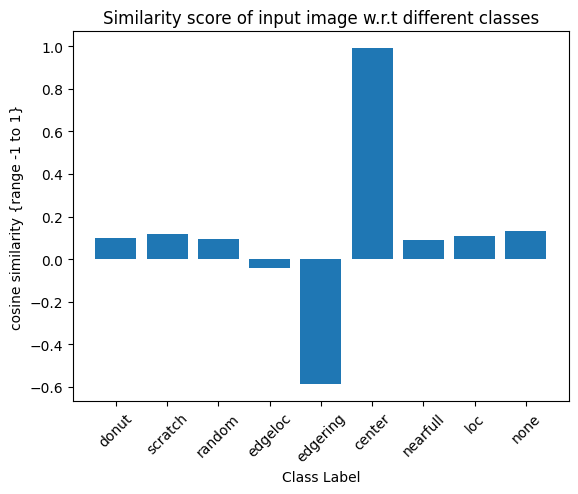

In [84]:
#Bar chart of class wise magnitudes of fingerprint vector

plt.bar(class_names.keys(), similarity_vec)
plt.xticks(list(class_names.keys()), class_names.values(), rotation=45)
plt.xlabel('Class Label')
plt.ylabel('cosine similarity {range -1 to 1}')
plt.title('Similarity score of input image w.r.t different classes')
plt.show()

# scaling cosine similarity to 0 - 1 range 

In [87]:
def normalize_distance(dist, min_dist, max_dist):
    if max_dist == min_dist:
        return 0.0
    else:
        return (dist - min_dist) / (max_dist - min_dist)

normalized_similarity_vector = [ normalize_distance(x,similarity_vec.min(), similarity_vec.max()) for x in similarity_vec]

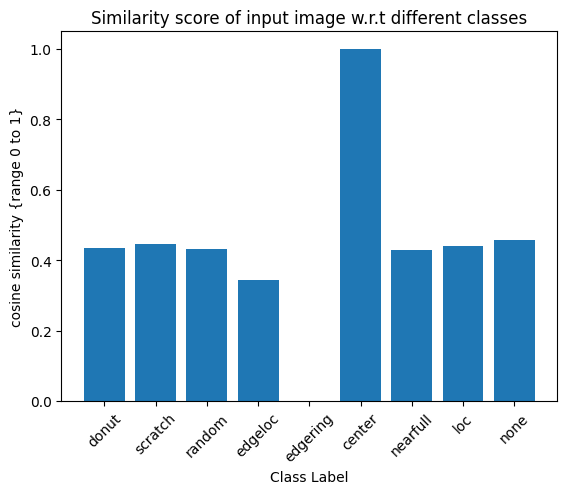

In [88]:
#Bar chart of class wise magnitudes of fingerprint vector in the range 0 - 1

plt.bar(class_names.keys(), normalized_similarity_vector)
plt.xticks(list(class_names.keys()), class_names.values(), rotation=45)
plt.xlabel('Class Label')
plt.ylabel('cosine similarity {range 0 to 1}')
plt.title('Similarity score of input image w.r.t different classes')
plt.show()

## Method 2: comparing image with the mean of embedding classes

In [89]:
embeddings = []
labels = []
with torch.no_grad():
    for (img, label) in tqdm(complete_data):
        img = resize(img, (64,64))
        img = torch.from_numpy(img)
        img = img.float().to(device)
        img = img.view(1,1,64,64)
        label = torch.from_numpy(np.array([label], dtype=np.float32))
        output = load_base_net(img)
        embeddings.append(output)
        labels.append(label)
        
embeddings = torch.cat(embeddings, dim=0).cpu()
labels = torch.cat(labels, dim=0).cpu()

100%|██████████| 10268/10268 [00:11<00:00, 928.28it/s]


In [90]:
class_wise_embeddings = {}
for i in range(9):
     class_wise_embeddings[i] = []
    
for i, (embedding, label) in enumerate(zip(embeddings, labels)):
    class_wise_embeddings[int(label)].append(embedding)

for key, value in class_wise_embeddings.items():
    count = len(value)
    print(f"Count of elements in {key}: {count}")


Count of elements in 0: 83
Count of elements in 1: 763
Count of elements in 2: 399
Count of elements in 3: 1582
Count of elements in 4: 1448
Count of elements in 5: 262
Count of elements in 6: 226
Count of elements in 7: 1411
Count of elements in 8: 4094


In [91]:
# Computing mean embeddings for each class

mean_class0 = torch.mean(torch.stack(class_wise_embeddings[0], dim =0), axis=0)
mean_class1 = torch.mean(torch.stack(class_wise_embeddings[1], dim =0), axis=0)
mean_class2 = torch.mean(torch.stack(class_wise_embeddings[2], dim =0), axis=0)
mean_class3 = torch.mean(torch.stack(class_wise_embeddings[3], dim =0), axis=0)
mean_class4 = torch.mean(torch.stack(class_wise_embeddings[4], dim =0), axis=0)
mean_class5 = torch.mean(torch.stack(class_wise_embeddings[5], dim =0), axis=0)
mean_class6 = torch.mean(torch.stack(class_wise_embeddings[6], dim =0), axis=0)
mean_class7 = torch.mean(torch.stack(class_wise_embeddings[7], dim =0), axis=0)
mean_class8 = torch.mean(torch.stack(class_wise_embeddings[8], dim =0), axis=0)

mean_of_embeddings =[mean_class0,mean_class1,mean_class2,mean_class3,mean_class4,mean_class5,mean_class6,mean_class7,mean_class8]


In [92]:
#Function to generate fingerprint vector considering the class centroids

def class_wise_cosine_dist(ip_img, data, model, centroids, label, print_plot = True):

    ip_img = to_tensor(ip_img).view((1,1,64,64)).to(device).float()
    
    ip_img_embed = model(ip_img)
    
    sim_0 = F.cosine_similarity(ip_img_embed, centroids[0].to(device)).item()
    sim_1 = F.cosine_similarity(ip_img_embed, centroids[1].to(device)).item()
    sim_2 = F.cosine_similarity(ip_img_embed, centroids[2].to(device)).item()
    sim_3 = F.cosine_similarity(ip_img_embed, centroids[3].to(device)).item()
    sim_4 = F.cosine_similarity(ip_img_embed, centroids[4].to(device)).item()
    sim_5 = F.cosine_similarity(ip_img_embed, centroids[5].to(device)).item()
    sim_6 = F.cosine_similarity(ip_img_embed, centroids[6].to(device)).item()
    sim_7 = F.cosine_similarity(ip_img_embed, centroids[7].to(device)).item()
    sim_8 = F.cosine_similarity(ip_img_embed, centroids[8].to(device)).item()

    similarity_op =  np.array([sim_0, sim_1, sim_2, sim_3, sim_4, sim_5, sim_6, sim_7, sim_8])
    
    max_idx = np.argmax(similarity_op)
    
    if print_plot == True:
        print(f"The defect pattern belongs to \033[1m'{class_names[max_idx]}'\033[0m with \033[1mclass:{max_idx}\033[0m")
        print()
        print("The different randomly picked images from each class for comparision are :")
        
        print(f"The fingerprint vector for a input image w.r.t 9 different defect patterns :- \n \033[1m{str(similarity_op)}\033[0m")
    return  similarity_op , max_idx

In [97]:
fingerprint_vec, pred_label = class_wise_cosine_dist(img , datasets, load_base_net, mean_of_embeddings, class_names, print_plot =True)

The defect pattern belongs to 'edgering' with class:4

The different randomly picked images from each class for comparision are :
The fingerprint vector for a input image w.r.t 9 different defect patterns :- 
 [-0.11770394 -0.76513851 -0.11067118  0.106466    0.99999607 -0.58920515
 -0.104444   -0.76177919 -0.06592095]


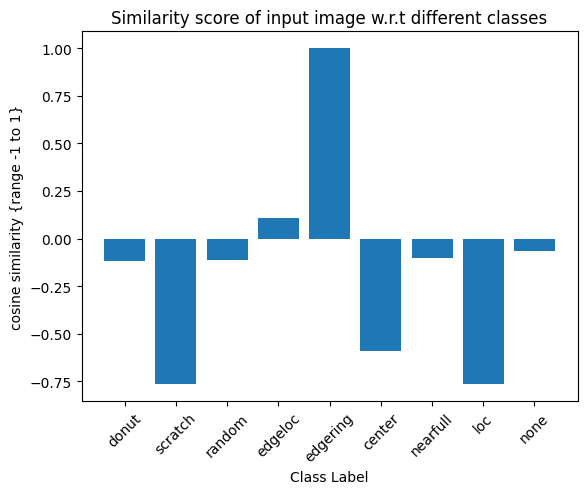

In [98]:
#Bar chart

plt.bar(class_names.keys(), fingerprint_vec)
plt.xticks(list(class_names.keys()), class_names.values(), rotation=45)
plt.xlabel('Class Label')
plt.ylabel('cosine similarity {range -1 to 1}')
plt.title('Similarity score of input image w.r.t different classes')
plt.show()

## Model Evaluation

In [100]:
test_data = donut_test + scratch_test + random_test + edgeloc_test + edgering_test + \
                  center_test + nearfull_test + loc_test + none_test
                                 
print(len(test_data))
random.shuffle(combined_data)

1032


100%|██████████| 1032/1032 [00:02<00:00, 444.05it/s]


Overall Accuracy: 0.8013565891472868
Class-wise Precision, Recall, F1-score:
               precision    recall  f1-score   support

       donut       0.00      0.00      0.00         9
     scratch       0.18      0.10      0.13        77
      random       0.82      0.35      0.49        40
     edgeloc       0.83      0.86      0.84       159
    edgering       0.89      0.99      0.94       145
      center       0.74      0.93      0.82        27
    nearfull       0.48      0.87      0.62        23
         loc       0.63      0.68      0.66       142
        none       0.94      0.93      0.93       410

    accuracy                           0.80      1032
   macro avg       0.61      0.64      0.60      1032
weighted avg       0.79      0.80      0.79      1032



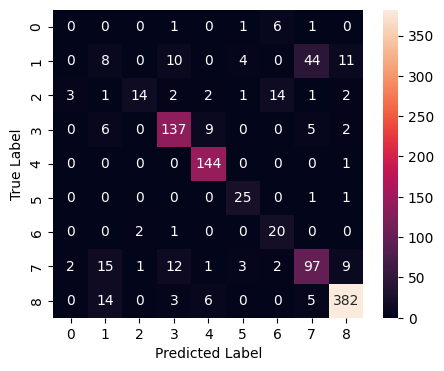

In [190]:
# Evauation for the model using performance metrics

from sklearn.metrics import classification_report

def class_wise_report(test_dataset, data, model, label):
    y_true =[]
    y_pred =[]
    for i in tqdm(range(len(test_dataset))):
        image = test_dataset[i][0]
        image_label = test_dataset[i][1]
        _ , pred_label = class_wise_cosine_dist(image , datasets, load_base_net, mean_of_embeddings, class_names, print_plot =False)

        y_true.append(image_label)
        y_pred.append(pred_label)
    
    accuracy = accuracy_score(y_true, y_pred)
    print('Overall Accuracy:', accuracy)
    
    class_names_str = [class_names[i] for i in class_names]

    class_report = classification_report(y_true, y_pred, target_names=class_names_str)
    print('Class-wise Precision, Recall, F1-score:\n', class_report)
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize = (5,4))
    sns.heatmap(cm, annot = True , fmt ='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    return accuracy, class_report, cm

accuracy, report, cm = class_wise_report(test_data, datasets, load_base_net, class_names)